# 준비

In [1]:
# Python 내장 Library

import pickle # pkl 파일을 처리합니다.
import tqdm

In [4]:
# Library를 불러옵니다.

# 데이터처리 Library
import pandas as pd  # DataFrame Library
import numpy as np # Array 연산 Library
import scipy # 과학 영역에서의 수치 연산 Library

# Machine Learning Library
import sklearn 
import mlxtend 

# 시각화 Library
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns  

# 한글 형태소분석 Library
import kiwipiepy 
from kiwipiepy import Kiwi

# 사용한 library 별 version을 확인합니다.
for i in [pd, np, sklearn, mlxtend, mpl, sns, kiwipiepy]:
    print(i.__name__, i.__version__)

pandas 2.1.1
numpy 1.26.1
sklearn 1.3.2
mlxtend 0.22.0
matplotlib 3.8.0
seaborn 0.13.0
kiwipiepy 0.16.1


# 추천이란?


**추천 = 사용자가 선택할 가능성에 높은 아이템에 대한 순위매김(Ranking)**

# 초간단 추천 로직 만들기

추천 로직을 직접 만들어 봄으로써 추천 시스템에 대한 연구의 본질을 파악해봅니다.

## Task

MovieLens 100K 데이터셋을 이용하여,

10개의 영화(movieId)를 추천하는 로직을 만듭니다.

현재 주어진 데이터에서 사용자들이 볼 가능성이 높은

영화를 추천하는 로직을 만들어 보아요!


## Dataset 불러 오기

데이터셋 크기가 작은 MovieLen 100K을 불러 옵니다.

In [5]:
df_ratings = pd.read_csv('dataset/ratings_100k.csv')
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv('dataset/users_100k.csv', index_col='user id')
df_movie = pd.read_csv('dataset/movies_100k.csv', index_col='movie id')

In [6]:
print("평점 데이터 크기", df_ratings.shape)
print("영화 정보 크기", df_movie.shape)
print("사용자 정보 크기", df_user.shape)

평점 데이터 크기 (100000, 4)
영화 정보 크기 (1682, 21)
사용자 정보 크기 (943, 4)


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user id  100000 non-null  int64         
 1   item id  100000 non-null  int64         
 2   rating   100000 non-null  int64         
 3   date     100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.1 MB


In [8]:
df_ratings.head()

,user id,item id,rating,date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [9]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 1 to 943
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         943 non-null    int64 
 1   gender      943 non-null    object
 2   occupation  943 non-null    object
 3   zip code    943 non-null    object
dtypes: int64(1), object(3)
memory usage: 36.8+ KB


In [10]:
df_user.head()

,age,gender,occupation,zip code
user id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [11]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movie title   1682 non-null   object
 1   release date  1681 non-null   object
 2   unknown       1682 non-null   int64 
 3   Action        1682 non-null   int64 
 4   Adventure     1682 non-null   int64 
 5   Animation     1682 non-null   int64 
 6   Children's    1682 non-null   int64 
 7   Comedy        1682 non-null   int64 
 8   Crime         1682 non-null   int64 
 9   Documentary   1682 non-null   int64 
 10  Drama         1682 non-null   int64 
 11  Fantasy       1682 non-null   int64 
 12  Film-Noir     1682 non-null   int64 
 13  Horror        1682 non-null   int64 
 14  Musical       1682 non-null   int64 
 15  Mystery       1682 non-null   int64 
 16  Romance       1682 non-null   int64 
 17  Sci-Fi        1682 non-null   int64 
 18  Thriller      1682 non-null   int64 
 19  War        

In [12]:
df_movie.head()

,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## 간단한 추천 로직을 만들어 봐요.

Rating은 추천 로직 평가할 만한 내용을 담고 있습니다.

사용자(user id)가 영화(movie id)를 시청한 후 평가를 했다고 가정합니다.


* 추천 시나리오

> 사용자(user id)와 시점(date)를 추천 로직에 제공합니다.

> 추천 로직은 사용자에게 10개의 **df_movie**에서 영화(movie id)를 제공합니다.

* 평가 시나리오

> Rating을 통해서 시청 여부를 파악합니다.

> 로직에서 받아온 10개의 영화(movie id) 중에 item id와 일치한다면, **Hit**로 정의합니다.

> 평가에 주어진 케이스에 대해 Hit한 확률을 지표로 합니다.


외부 데이터를 제외하고 **df_user**와 **df_movie**를 가지고,

그럼 추천 간단한 로직을 만들어 보겠습니다. 

df_rating을 통해 제작한 추천로직의 성능을 측정하는데 활용해 봅니다.


In [13]:
# 추천 결과에 대한 평가 로직입니다.
def evaluate(df_eval, rcmd_func):
    """
    평가 데이터와 추천 로직을 입력 받아 추천 지표 (Hit ratio)를 계산합니다.
    Parameters:
        df_evel: pd.DataFrame
            평가 데이터프레임: user id / item id / date 형태로 되어 있습니다.
        rcmd_func: function
            추천 로직 callback, user_id와 date를 전달하면 이에 따른  10개의 movie_id를 가직 리스트를 반환해줍니다.
    Returns:
        Hit ratio
    """
    result = list()
    # user id와 date를 rcmd_func의 인자로 전달하고 rcmd_func
    # rcmd_func가 반환한 리스트  item id가 있으면 True(Hit)로 기록합니다.
    for x in tqdm.tqdm(df_eval[['user id', 'item id', 'date']].values):
        result.append( x[1] in set(rcmd_func(x[0], x[2])[:10])) # 10개까지 만을 체크합니다.
    return np.mean(result) # True(Hit)인 비율, 즉 Hit Ratio를 반환합니다.

def to_movie_title(movie_ids):
    """
    movie id 리스트에 대한 제목을 출력합니다.
    Parameters:
        movie_ids: list
            제목을 출력할 영화 ID 리스트
    """
    for i, movie_id in enumerate(movie_ids):
        print(i + 1, df_movie.loc[movie_id, ['movie title', 'release date']].tolist())

예제) 랜덤으로 추천합니다. ^^

## Task 1

출시한 시점과 가장 가까운 30개의 콘텐츠 중에서 10개를 랜덤으로 해봅니다.

In [18]:
np.random.seed(123) # 랜덤 로직의 동일한 결과를 위해 seed를 줍니다.
n_sel = 30
df_movie.sort_values('release date', ascending=False)
def recent_random_rcmd(user_id, date):
    # To-Do: date보다 출시 연도가 오래된 영화중에서 출시 시점이 가까운 30개의 영화를 Random으로 10개를 뽑아 주는 로직을 만듭니다.

In [19]:
# 테스트로 결과를 뽑아봅니다.
to_movie_title(recent_random_rcmd(None, '1997-01-01'))

1 ['Whole Wide World, The (1996)', Timestamp('1996-12-25 00:00:00')]
2 ['Jingle All the Way (1996)', Timestamp('1996-11-22 00:00:00')]
3 ['Thieves (Voleurs, Les) (1996)', Timestamp('1996-12-25 00:00:00')]
4 ['101 Dalmatians (1996)', Timestamp('1996-11-27 00:00:00')]
5 ['Michael (1996)', Timestamp('1996-12-25 00:00:00')]
6 ['Crucible, The (1996)', Timestamp('1996-11-27 00:00:00')]
7 ['Beavis and Butt-head Do America (1996)', Timestamp('1996-12-20 00:00:00')]
8 ['Substance of Fire, The (1996)', Timestamp('1996-12-06 00:00:00')]
9 ['Scream (1996)', Timestamp('1996-12-20 00:00:00')]
10 ['Daylight (1996)', Timestamp('1996-12-06 00:00:00')]


In [20]:
# 평가를 합니다.
evaluate(df_ratings, recent_random_rcmd)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [00:16<00:00, 6023.13it/s]


0.006

## Task 2

사용자의 나이가 13세 이하일 경우 movie의 Children's가 0인 것에서 랜덤으로 뽑고, 

초과할 경우에는 Children's가 1인 것에서 랜덤으로 뽑습니다.

In [21]:
# 동일한 결과를 위해 seed를 줍니다.
# 나이를 기준으로 어린이는 Children's로 추천합니다.
np.random.seed(123)
n_age = 13
def age_random_rcmd(user_id, date):
    # To-Do: df_user에서 user_id의 연령을 가져와서, 
    # 13세 이하이면 Children's가 1인 것에서 랜덤으로 뽑고
    # 13세 이상이면 Children's가 0인 것에서 랜덤으로 뽑습니다.

evaluate(df_ratings, age_random_rcmd)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6540.53it/s]


0.00575

In [22]:
to_movie_title(age_random_rcmd(30, None))

1 ['Heavyweights (1994)', Timestamp('1994-01-01 00:00:00')]
2 ['Space Jam (1996)', Timestamp('1996-11-15 00:00:00')]
3 ['First Kid (1996)', Timestamp('1996-08-30 00:00:00')]
4 ['Homeward Bound II: Lost in San Francisco (1996)', Timestamp('1996-03-08 00:00:00')]
5 ['Beauty and the Beast (1991)', Timestamp('1991-01-01 00:00:00')]
6 ['Love Bug, The (1969)', Timestamp('1969-01-01 00:00:00')]
7 ['Fluke (1995)', Timestamp('1995-01-01 00:00:00')]
8 ['Indian in the Cupboard, The (1995)', Timestamp('1995-01-01 00:00:00')]
9 ['Escape to Witch Mountain (1975)', Timestamp('1975-01-01 00:00:00')]
10 ['Zeus and Roxanne (1997)', Timestamp('1997-01-10 00:00:00')]


In [23]:
df_ratings.loc[df_ratings['user id'].isin(df_user.query('age <= 15').index)]

,user id,item id,rating,date
328,101,829,3,1997-10-18 00:55:38
372,142,169,5,1998-02-28 04:32:36
526,281,338,2,1997-12-04 01:54:17
662,101,304,3,1997-10-18 00:47:57
1191,206,302,5,1998-02-22 20:43:47
...,...,...,...,...
99806,880,5,3,1997-11-22 23:29:39
99875,887,274,1,1997-12-06 03:21:18
99889,887,1063,1,1997-12-06 03:53:24
99976,618,628,2,1998-03-31 01:33:39


## Task 3 

평점 이력은 사용하지 말고, 

자유롭게 추천 로직을 만들어 봅니다.

**평점 이력**을 사용해보겠습니다.

데이터의 일부를 추천 로직을 만드는 데 사용하고, 

그 외의 데이터는 추천 로직 평가에 사용해봅니다.

이를 위해서, 로직을 만드는 것은 

**df_rating**에서 1998-03-01 전의 데이터를 

평가는 1998-03-01 이후의 데이터를 사용합니다.


외부 데이터를 제외하고 **df_user**와 **df_movie**를 가지고,

그럼 추천 로직을 만들어 보겠습니다. 

굉장한 추천 로직을 만들라는 것이 아닙니다. 이 상황에서 아주 간단하게 해볼 수 있는 것을 해보세요~

In [24]:
# 추천 로직을 만들기 위한 데이터
df_logic = df_ratings.query('date < "1998-03-01"')

# 추천 결과를 평가하기 위한 데이터
df_eval = df_ratings.query('date >= "1998-03-01"')
len(df_logic), len(df_eval)

(77985, 22015)

가설: 기존에 많이 봤던 것은 여전히 많이 볼 것입니다.

평가(시청)가 많은 영화순으로 추천해 봅니다.

In [25]:
s_viewcnt = df_logic['item id'].value_counts()
def mostview_recommender(userId, date):
    return s_viewcnt.iloc[:10].index
evaluate(df_eval, mostview_recommender)

100%|█████████████████████████████████████████████████████████████████████████| 22015/22015 [00:00<00:00, 117247.99it/s]


0.04524188053599818

가설: 시의성이 있어 최근에 본 것을 볼 가능성이 높습니다.

최근에 평가(시청)가 많은 영화순으로 추천해 봅니다.

In [26]:
s_viewcnt = # To-Do: 1998-01-01 이후의 평점 중에서 영화별 평점 카운트를 가져옵니다.
def mostview_recommender(userId, date):
    return s_viewcnt.iloc[:10].index
evaluate(df_eval, mostview_recommender)

100%|█████████████████████████████████████████████████████████████████████████| 22015/22015 [00:00<00:00, 118180.48it/s]


0.05141948671360436

가설: 평점이 높을 수록 시청할 가능성이 높을 것입니다.

In [27]:
# 어느 정도(여기서는 20건 이상) 평점이 높은 것 위주로 추천합니다.
# 평점이 높은 위주로 추천합니다.
s_rating = # To-Do-With
def mostrating_recommender(userId, date):
    return s_rating.iloc[:10].index
evaluate(df_eval, mostrating_recommender)

100%|█████████████████████████████████████████████████████████████████████████| 22015/22015 [00:00<00:00, 103700.94it/s]


0.027481262775380422

가설: 시청했던 것을 다시 시청하지 않을 것입니다.

In [28]:
# 최근에 (1998-01-01 이후)많이 봤던 것 중에서 시청하지 않은 것을 추천합니다.
s_user_hist = # To-Do-With
s_viewcnt = # To-Do-With
def mostview_notseen_recommender(userId, date):
    if userId in s_user_hist:
        return # To-Do-With
    else:
        return s_viewcnt.iloc[:10].index

evaluate(df_eval, mostview_notseen_recommender)

100%|██████████████████████████████████████████████████████████████████████████| 22015/22015 [00:00<00:00, 37765.97it/s]


0.055961844197138316

### 사용자 성별 통계

Ex) 성별에 따라 평가를 한 영화의 차이를 살펴 보자

성별(gender)에 따른 선호도에 차이가 있을지 봅니다.

최근에 (1998-01-01 이후)에 성별로 Top 10 시청 영화를 살펴 보겠습니다.

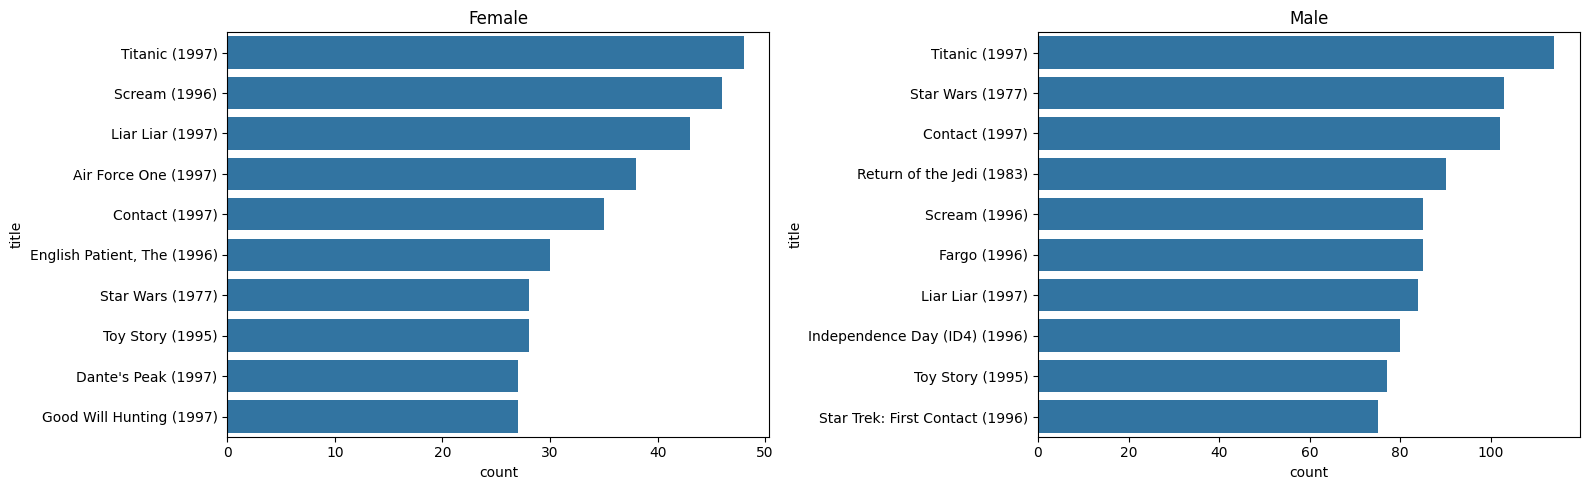

In [29]:
df_gender_most10 = # To-Do-With
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(data=df_gender_most10.loc['F'], x='count', y='title', ax=axes[0])
axes[0].set_title('Female')
sns.barplot(data=df_gender_most10.loc['M'], x='count', y='title', ax=axes[1])
axes[1].set_title('Male')

plt.tight_layout()
plt.show()

성별에 따른 Top 10의 차이가 보이긴 합니다.

이를 기반으로 다음 가설을 해봅니다.

가설: 성별에 따라 Top 10을 뽑아 추천하면 효과가 높을 것이다.

조회수를 보고 개선 여지를 확인해봅니다.

In [30]:
s_gender_rcmd = df_logic.query('date > "1998-01-01"').groupby(
    df_logic['user id'].map(df_user['gender'])
).apply(lambda x: x['item id'].value_counts().iloc[:10].index.values)

In [31]:
to_movie_title(s_gender_rcmd.loc['F'])

1 ['Titanic (1997)', Timestamp('1997-01-01 00:00:00')]
2 ['Scream (1996)', Timestamp('1996-12-20 00:00:00')]
3 ['Liar Liar (1997)', Timestamp('1997-03-21 00:00:00')]
4 ['Air Force One (1997)', Timestamp('1997-01-01 00:00:00')]
5 ['Contact (1997)', Timestamp('1997-07-11 00:00:00')]
6 ['English Patient, The (1996)', Timestamp('1996-11-15 00:00:00')]
7 ['Star Wars (1977)', Timestamp('1977-01-01 00:00:00')]
8 ['Toy Story (1995)', Timestamp('1995-01-01 00:00:00')]
9 ["Dante's Peak (1997)", Timestamp('1997-02-07 00:00:00')]
10 ['Good Will Hunting (1997)', Timestamp('1997-01-01 00:00:00')]


In [32]:
to_movie_title(s_gender_rcmd.loc['M'])

1 ['Titanic (1997)', Timestamp('1997-01-01 00:00:00')]
2 ['Star Wars (1977)', Timestamp('1977-01-01 00:00:00')]
3 ['Contact (1997)', Timestamp('1997-07-11 00:00:00')]
4 ['Return of the Jedi (1983)', Timestamp('1997-03-14 00:00:00')]
5 ['Scream (1996)', Timestamp('1996-12-20 00:00:00')]
6 ['Fargo (1996)', Timestamp('1997-02-14 00:00:00')]
7 ['Liar Liar (1997)', Timestamp('1997-03-21 00:00:00')]
8 ['Independence Day (ID4) (1996)', Timestamp('1996-07-03 00:00:00')]
9 ['Toy Story (1995)', Timestamp('1995-01-01 00:00:00')]
10 ['Star Trek: First Contact (1996)', Timestamp('1996-11-22 00:00:00')]


In [33]:
to_movie_title(set(s_gender_rcmd.loc['F']) - set(s_gender_rcmd.loc['M']))

1 ['Good Will Hunting (1997)', Timestamp('1997-01-01 00:00:00')]
2 ["Dante's Peak (1997)", Timestamp('1997-02-07 00:00:00')]
3 ['Air Force One (1997)', Timestamp('1997-01-01 00:00:00')]
4 ['English Patient, The (1996)', Timestamp('1996-11-15 00:00:00')]


In [34]:
to_movie_title(set(s_gender_rcmd.loc['M']) - set(s_gender_rcmd.loc['F']))

1 ['Independence Day (ID4) (1996)', Timestamp('1996-07-03 00:00:00')]
2 ['Fargo (1996)', Timestamp('1997-02-14 00:00:00')]
3 ['Return of the Jedi (1983)', Timestamp('1997-03-14 00:00:00')]
4 ['Star Trek: First Contact (1996)', Timestamp('1996-11-22 00:00:00')]


In [35]:
# 성별로 많이 본 것을 추천합니다.
def mostview_gender_recommender(userId, date):
    return # To-Do-With

evaluate(df_eval, mostview_gender_recommender)

100%|█████████████████████████████████████████████████████████████████████████| 22015/22015 [00:00<00:00, 120979.82it/s]


0.04719509425391778

가정: 사용자가 가장 마지막에 시청한 영화를 시청한 사용자가 많이 시청한 영화를 성능이 좋아질 것이다.

In [36]:
# 사용자별 영화 시청 내역 
s_user_hist = df_logic.groupby('user id')['item id'].apply(set)

In [37]:
df_logic

,user id,item id,rating,date
0,196,242,3,1997-12-04 15:55:49
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
5,298,474,4,1998-01-07 14:20:06
...,...,...,...,...
99995,880,476,3,1997-11-22 05:10:44
99996,716,204,5,1997-11-17 19:39:03
99997,276,1090,1,1997-09-20 22:49:55
99998,13,225,2,1997-12-17 22:52:36


In [38]:
s_user_hist = # To-Do-With: 사용자별 시청한 평가한 영롸(item id)을 리스트로 만들어 pd.Series에 정리합니다.

s_rcmd_table = # To-Do-With: 영화별로 시청했던 사용자(user id)들이 평가한 영화 중에서 빈도수가 높은 10개의 영화들을 

In [ ]:
def most_recent_movie_recommender(userId, date):
    if userId in s_user_hist:
        return # To-Do-With: 사용자가 평가한 마직막 영화의 리스트를 s_rcmd_tabl 에서 가져옵니다.
    else:
        return s_viewcnt.iloc[:10].index

evaluate(df_eval, most_recent_movie_recommender)

# 추천 시스템의 요소

사용자(User): 서비스 이용자

 > MovieLens 회원

아이템(Item): 서비스 아이템

 > 영화

피드백 데이터: 사용자의 아이템에 대한 평가 이력

 > 명시적 피드백 (Explicit Feedback) : 선호도를 직접 나타내는 데이터: Ex) 평가 이력
   
 > 암시적 피드백 (Implicit Feedback) : 선호도를 직접 나타내지 않고 선호를 짐작할 수 데이터: Ex) 조회 이력

추천 목표: 

 > 가장 볼 가능성이 높은 영화을 제시

추천 내용: 

 > 영화 10개 추천
 
**추천의 평가**: 추천 결과를 정량화하여 측정
  
 > 추천의 목표에서 추천의 평가할 지표를 정의: Hit Rate
 
 > 평가 이력에서 사용자와 시점 정보를 넘겨 Hit Rate를 계산

**추천 방법**: 추천 목표를 달성하기 위한 내용을 만들어내기 위한 프로세스

 > 최신 영화
 
 > 가장 많이 시청한 영화
  

# 추천 알고리즘 설계 과정

1. 추천 시나리오 분석

  > 사용자와 시점에 따라 시청 가능성이 높은 10개의 영화를 추천

2. 데이터 수집

  > MovieLens 데이터

3. 추천 알고리즘 평가 방법 정의

  > 평가 지표: Hit Ratio
  
  > MovieLens 데이터의 rating 기록에서 user id와 time을 주고, 추천 받은 10개의 영화를 받아 Hit 여부를 집계

4. 추천 알고리즘 개발 
 
  > 최근에 나온 영화 위주 / 13세 이하는 Children's에서 추천 / 최근에 많이 평가한 콘텐츠 .... 
  
  > Machine Learning을 통한 예측 모델 활용

# 추천 시스템의 유형

## 협업 필터링(Collaborative Filtering)

사용자의 아이템에 대한 피드백을 기반으로 추천합니다.

> Big Data에서 아이템과 사용자의 특성과 상호작용의 양상을 반영하여 추천을 하기 위해서는 머신러닝(Machine Learning)이 필요합니다.

## 콘텐츠 기반의 추천 (Content-based Recommendation)

아이템의 콘텐츠(내용, Contents) 기반으로 추천합니다.

> 연산 기기(Computer)에 아이템의 내용이 지닌 의미 나타내기 위해 머신러닝(Machine Learning)이 필요합니다.